In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [4]:
df['diabetes'].value_counts()

diabetes
0    91500
1     8500
Name: count, dtype: int64

<Axes: >

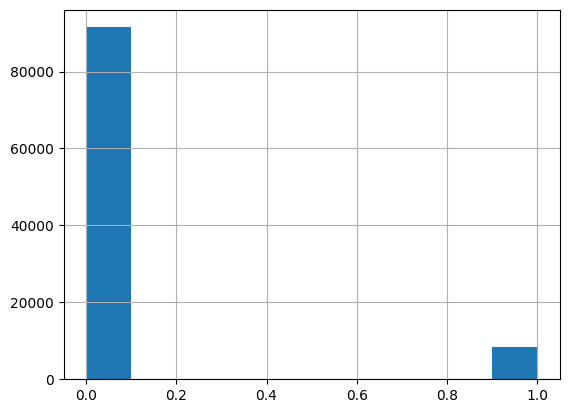

In [5]:
df['diabetes'].hist()

In [6]:
df = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)

In [7]:
corr_matrix = df.corr()['diabetes'].sort_values(ascending=False)

print("Korrelationen mit der Zielvariable (diabetes):")
print(corr_matrix)

Korrelationen mit der Zielvariable (diabetes):
diabetes                       1.000000
blood_glucose_level            0.419558
HbA1c_level                    0.400660
age                            0.258008
bmi                            0.214357
hypertension                   0.197823
heart_disease                  0.171727
smoking_history_former         0.097917
gender_Male                    0.037666
smoking_history_never          0.027267
smoking_history_ever           0.024080
smoking_history_not current    0.020734
smoking_history_current        0.019606
gender_Other                  -0.004090
Name: diabetes, dtype: float64


C:\Users\Timothy\AppData\Local\Temp\ipykernel_9628\965017608.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_matrix.values, y=corr_matrix.index, palette="viridis")


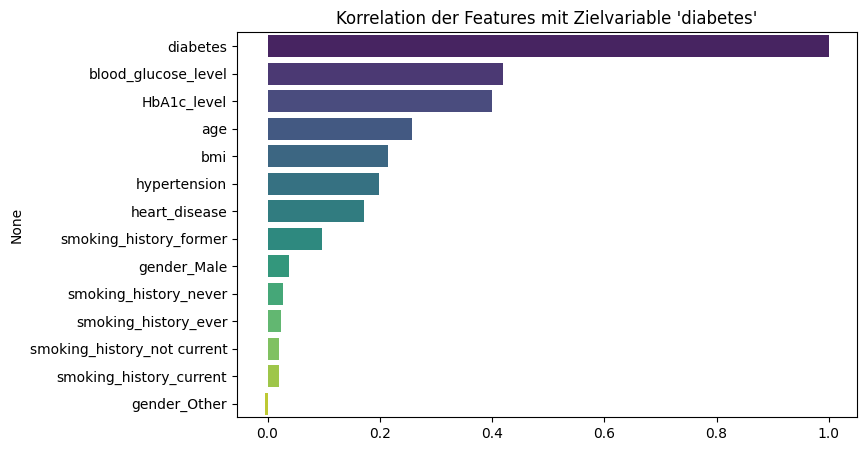

In [8]:
plt.figure(figsize=(8,5))
sns.barplot(x=corr_matrix.values, y=corr_matrix.index, palette="viridis")
plt.title("Korrelation der Features mit Zielvariable 'diabetes'")
plt.show()

## NEW COMPARISON ## - age vs diabetes


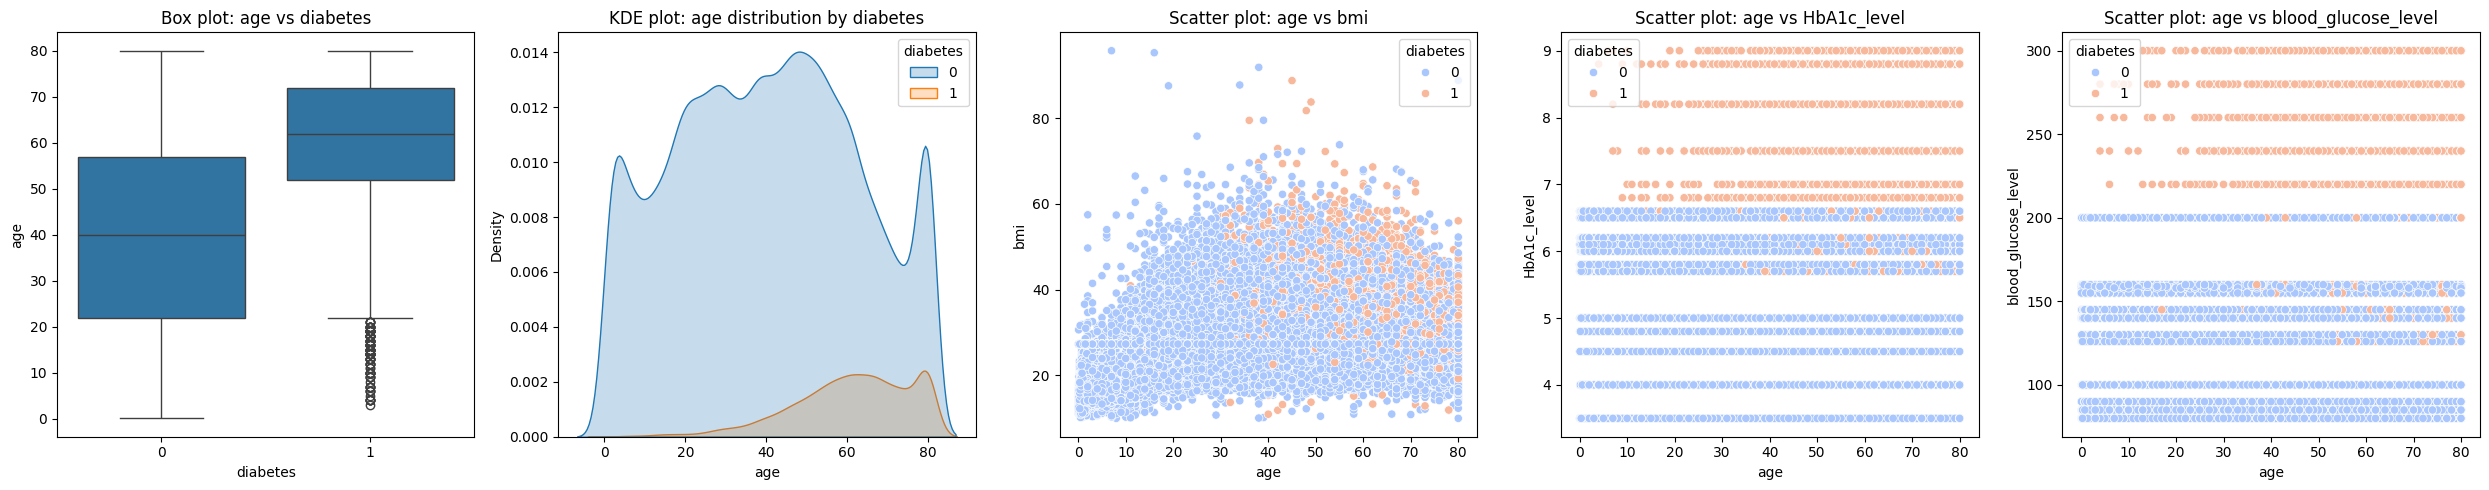

## NEW COMPARISON ## - bmi vs diabetes


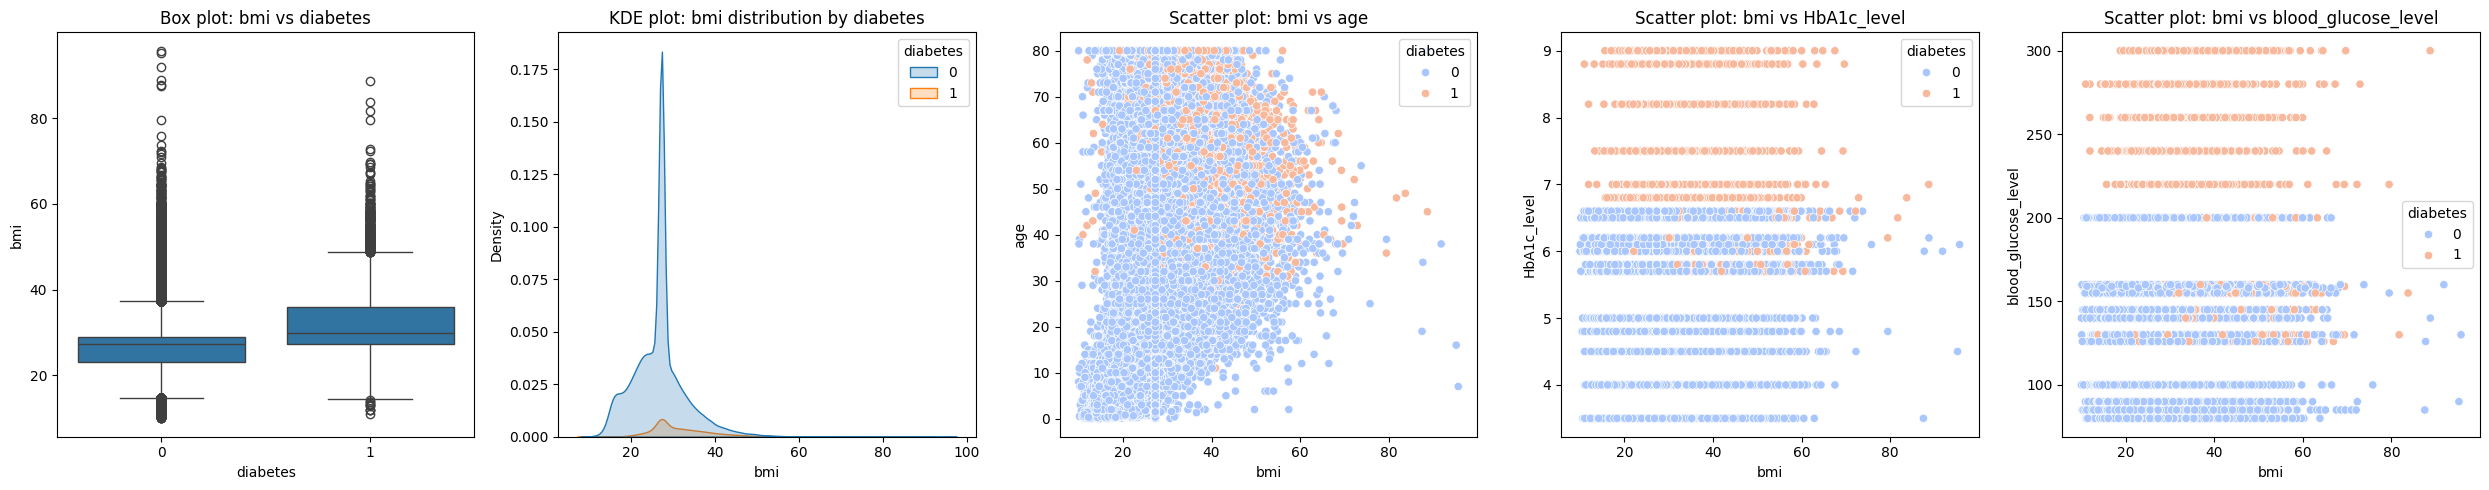

## NEW COMPARISON ## - HbA1c_level vs diabetes


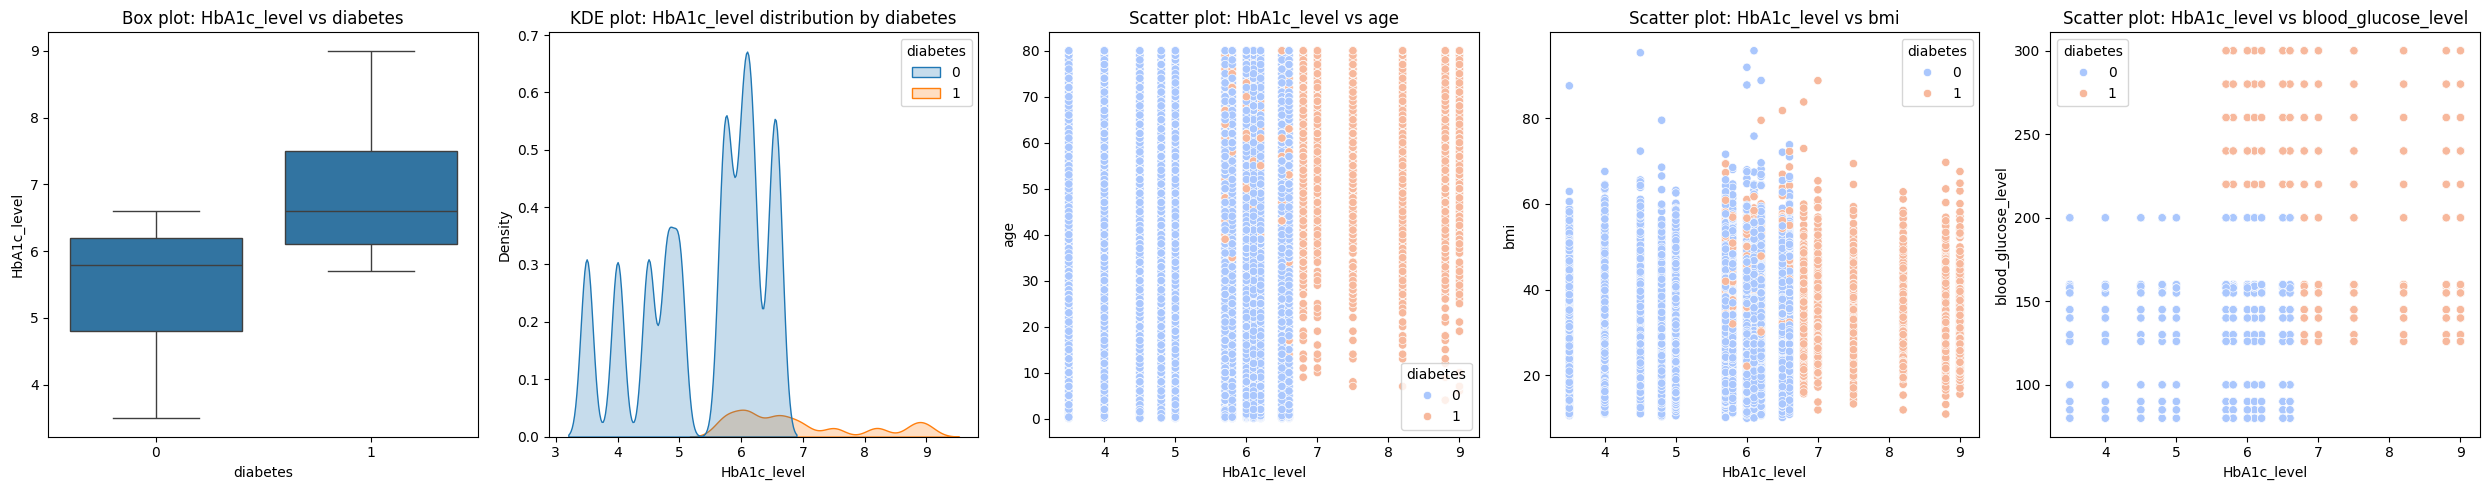

## NEW COMPARISON ## - blood_glucose_level vs diabetes


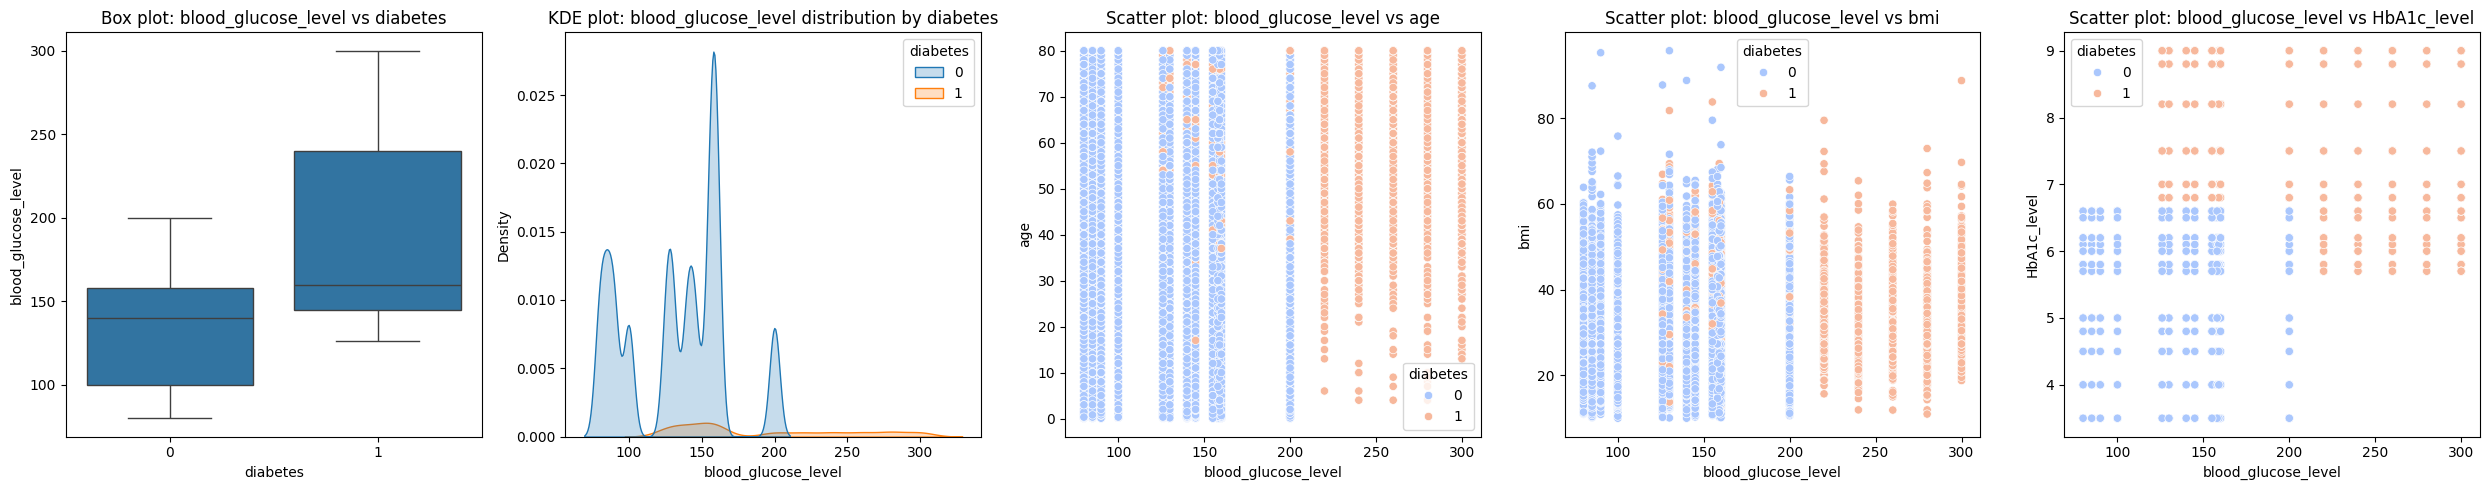

In [9]:
# Liste von Features, die wir genauer anschauen wollen
# (du kannst diese Liste je nach Interesse ändern)
suspected_columns = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
target_variable = 'diabetes'  # Zielvariable

# Iteriere durch die Features und erstelle Plots
for feature in suspected_columns:
    print(f"## NEW COMPARISON ## - {feature} vs {target_variable}")
    
    # Anzahl der anderen Features außer dem aktuellen
    num_other_features = len([col for col in suspected_columns if col != feature])
    
    # Layout: 1 Reihe, Boxplot + KDE + Scatterplots
    fig, axes = plt.subplots(1, 2 + num_other_features, figsize=(5 * (2 + num_other_features), 5))
    
    # 1. Boxplot: Feature vs Target
    sns.boxplot(x=target_variable, y=feature, data=df, ax=axes[0])
    axes[0].set_title(f'Box plot: {feature} vs {target_variable}')
    
    # 2. KDE-Plot: Feature-Verteilung nach Target
    sns.kdeplot(x=feature, hue=target_variable, data=df, fill=True, ax=axes[1])
    axes[1].set_title(f'KDE plot: {feature} distribution by {target_variable}')
    
    # 3+. Scatterplots: Feature vs andere Features
    for i, other_feature in enumerate([col for col in suspected_columns if col != feature]):
        sns.scatterplot(x=feature, y=other_feature, hue=target_variable, data=df, palette="coolwarm", ax=axes[i+2])
        axes[i+2].set_title(f'Scatter plot: {feature} vs {other_feature}')
    
    plt.tight_layout()
    plt.show()


In [10]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,True,False,True,False,False,False,False


In [11]:
df.shape

(100000, 14)

In [12]:
# Alles außer der Zielvariable
X = df.drop("diabetes", axis=1)

# Nur die Zielvariable
y = df["diabetes"]

# Falls du später sicherstellen willst, dass y numerisch ist:
y = y.astype(int)

print("Shape X:", X.shape)
print("Shape y:", y.shape)


Shape X: (100000, 13)
Shape y: (100000,)


In [13]:
from sklearn.feature_selection import SelectKBest, chi2

# Sicherstellen, dass alle Werte >= 0 sind (Chi² benötigt das)
X_chi = X.copy()
X_chi = np.abs(X_chi)  # negative Werte vermeiden

# Chi²-Test anwenden
chi2_selector = SelectKBest(score_func=chi2, k="all")
chi2_selector.fit(X_chi, y)

# Ergebnisse in DataFrame
chi2_scores = pd.DataFrame({
    "Feature": X.columns,
    "Score": chi2_selector.scores_
}).sort_values(by="Score", ascending=False)

print(chi2_scores)


                        Feature          Score
5           blood_glucose_level  211290.674736
0                           age   80576.722304
3                           bmi    7407.898843
1                  hypertension    3620.485416
4                   HbA1c_level    3329.139367
2                 heart_disease    2832.761069
10       smoking_history_former     869.114789
6                   gender_Male      83.096327
9          smoking_history_ever      55.663898
11        smoking_history_never      48.255687
12  smoking_history_not current      40.216992
8       smoking_history_current      34.868272
7                  gender_Other       1.672131


                        Feature  Fisher_Score
5           blood_glucose_level  21363.054361
4                   HbA1c_level  19122.211184
0                           age   7131.405852
3                           bmi   4816.113932
1                  hypertension   4072.706875
2                 heart_disease   3038.559564
10       smoking_history_former    968.042101
6                   gender_Male    142.073969
11        smoking_history_never     74.402011
9          smoking_history_ever     58.018125
12  smoking_history_not current     43.006086
8       smoking_history_current     38.451597
7                  gender_Other      1.672427


C:\Users\Timothy\AppData\Local\Temp\ipykernel_9628\2110638536.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Fisher_Score", y="Feature", data=fisher_scores, palette="mako")


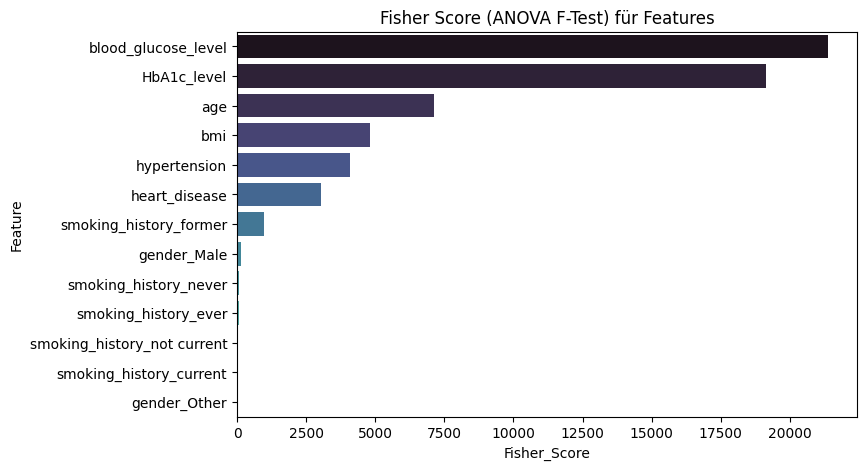

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif

# F-Test (Fisher Score)
fisher_selector = SelectKBest(score_func=f_classif, k="all")
fisher_selector.fit(X, y)

# Ergebnisse in DataFrame packen
fisher_scores = pd.DataFrame({
    "Feature": X.columns,
    "Fisher_Score": fisher_selector.scores_
}).sort_values(by="Fisher_Score", ascending=False)

print(fisher_scores)

# Plotten
plt.figure(figsize=(8,5))
sns.barplot(x="Fisher_Score", y="Feature", data=fisher_scores, palette="mako")
plt.title("Fisher Score (ANOVA F-Test) für Features")
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Schritt 1: 70% Training, 30% temporary (Test + Validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Schritt 2: 15% Test, 15% Validation (Hälfte von X_temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Trainingsdaten:", X_train.shape)
print("Validierungsdaten:", X_val.shape)
print("Testdaten:", X_test.shape)

# Skalierung (StandardScaler)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


Trainingsdaten: (70000, 13)
Validierungsdaten: (15000, 13)
Testdaten: (15000, 13)


In [16]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,5.0,155,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,4.8,155,0,True,False,True,False,False,False,False


In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Definiere das Modell
model_4 = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # 13 Features
    layers.BatchNormalization(),
    
    layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.3),
    
    layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.2),
    
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # 1 Node, weil binäre Klassifikation
])

# Kompilieren
model_4.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,573 (13.96 KB)

 Trainable params: 3,547 (13.86 KB)

 Non-trainable params: 26 (104.00 B)

In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Klassenverteilung
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

# In Dictionary-Format umwandeln für Keras
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights:", class_weight_dict)

Class Weights: {np.int64(0): np.float64(0.546448087431694), np.int64(1): np.float64(5.882352941176471)}


In [20]:
# Callbacks für Optimierung
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True)

# Training
history = model_4.fit(
    x=X_train, 
    y=y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    batch_size=128,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8293 - auc: 0.9309 - loss: 0.3864 - val_accuracy: 0.8671 - val_auc: 0.9648 - val_loss: 0.3107 - learning_rate: 0.0010
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8687 - auc: 0.9576 - loss: 0.3001 - val_accuracy: 0.8767 - val_auc: 0.9672 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8736 - auc: 0.9623 - loss: 0.2747 - val_accuracy: 0.8697 - val_auc: 0.9710 - val_loss: 0.2620 - learning_rate: 0.0010
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8742 - auc: 0.9658 - loss: 0.2562 - val_accuracy: 0.8894 - val_auc: 0.9728 - val_loss: 0.2376 - learning_rate: 0.0010
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8804 - auc: 0.9689 - loss: 0.2414 - val_accuracy: 0.8811 - val_auc: 0.9757 - val_loss: 0.2239 - learning_rate: 0.0010
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8807 - a

<Axes: >

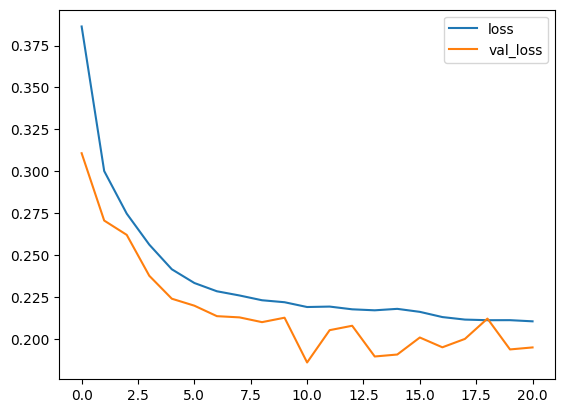

In [21]:
loss_df = pd.DataFrame(model_4.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

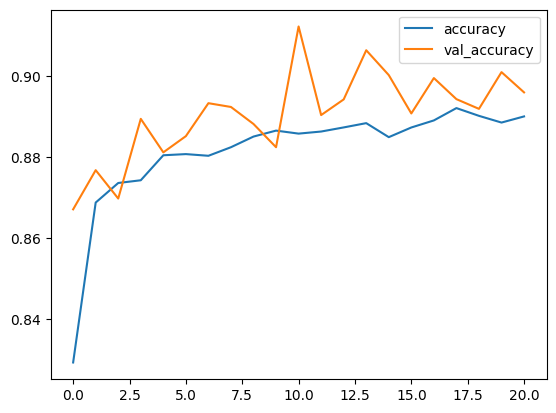

In [22]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [23]:
from tensorflow.keras.models import load_model
best_trained_model = load_model("best_model.keras")

In [24]:
print("Test data evaluation:")
print(best_trained_model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(best_trained_model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.18681244552135468, 0.9123333096504211, 0.9752808809280396]

Train data evaluation:
[0.1890183389186859, 0.9093571305274963, 0.9762910604476929]


In [25]:
# Vorhersagen: Wahrscheinlichkeiten (zwischen 0 und 1)
y_pred_proba = best_trained_model.predict(X_test)

# Umwandeln in Klassen (0 oder 1) mit Threshold 0.5
test_predictions = (y_pred_proba > 0.5).astype(int).flatten()

# y_test muss nicht mit argmax umgewandelt werden,
# weil es schon 0/1-Klassen enthält
print("Beispiel Wahrscheinlichkeiten:", y_pred_proba[:10].flatten())
print("Beispiel Predictions:", test_predictions[:10])
print("Beispiel Ground Truth:", y_test[:10].values)


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Beispiel Wahrscheinlichkeiten: [2.4570502e-01 3.8059760e-08 4.6944626e-10 1.2913948e-01 5.7753742e-02
 2.8530324e-03 7.2205508e-01 1.0689419e-03 1.2598520e-05 6.9627154e-01]
Beispiel Predictions: [0 0 0 0 0 0 1 0 0 1]
Beispiel Ground Truth: [0 0 0 0 0 0 0 0 0 0]


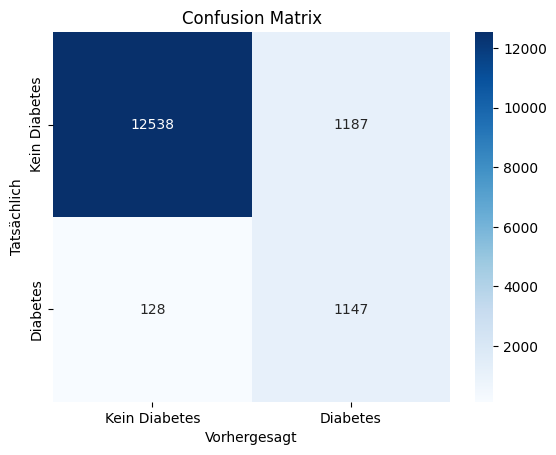

In [26]:
cm = confusion_matrix(y_test, test_predictions)

sns.heatmap(cm, annot=True, fmt='g', cmap="Blues",
            xticklabels=["Kein Diabetes", "Diabetes"],
            yticklabels=["Kein Diabetes", "Diabetes"])
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title("Confusion Matrix")
plt.show()

In [27]:
from sklearn.metrics import classification_report, accuracy_score

# Classification Report
print(classification_report(y_test, test_predictions, target_names=["Kein Diabetes", "Diabetes"]))

# Accuracy berechnen
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))


               precision    recall  f1-score   support

Kein Diabetes       0.99      0.91      0.95     13725
     Diabetes       0.49      0.90      0.64      1275

     accuracy                           0.91     15000
    macro avg       0.74      0.91      0.79     15000
 weighted avg       0.95      0.91      0.92     15000


Model overall accuracy: 91.23%


In [28]:
from sklearn.metrics import roc_auc_score

# ROC-AUC Score berechnen
auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score: {:.4f}".format(auc))


ROC-AUC Score: 0.9753


In [29]:
X.columns

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'gender_Male', 'gender_Other',
       'smoking_history_current', 'smoking_history_ever',
       'smoking_history_former', 'smoking_history_never',
       'smoking_history_not current'],
      dtype='object')

In [30]:
df.head(3)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,5.7,158,0,True,False,False,False,False,True,False


In [31]:
tester_row = {
    'age': 45,
    'hypertension': 1,
    'heart_disease': 0,
    'bmi': 32.5,
    'HbA1c_level': 6.8,
    'blood_glucose_level': 155,
    'gender_Male': 1,        
    'gender_Other': 0,
    'smoking_history_current': 0,
    'smoking_history_ever': 1,
    'smoking_history_former': 0,
    'smoking_history_never': 0,
    'smoking_history_not current': 0
}

# In DataFrame umwandeln
tester_df = pd.DataFrame([tester_row])

# Gleiche Skalierung wie Trainingsdaten anwenden!
tester_scaled = scaler.transform(tester_df)

# Prediction mit dem trainierten Modell
proba = best_trained_model.predict(tester_scaled)[0][0]   # Wahrscheinlichkeit für "Diabetes"
prediction = int(proba > 0.5)                # 0 = Kein Diabetes, 1 = Diabetes

# Ausgabe
np.set_printoptions(precision=4, suppress=True)
print(f"Predicted Class: {'Diabetes' if prediction==1 else 'Kein Diabetes'}")
print(f"Wahrscheinlichkeit für Diabetes: {proba:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Class: Diabetes
Wahrscheinlichkeit für Diabetes: 0.8165


In the initial training phase, the model achieved a very high overall accuracy of around 97%. However, because of the strong class imbalance in the dataset (91,500 non-diabetes cases compared to only 8,500 diabetes cases), the results were biased towards the majority class. While precision and recall for the non-diabetes class were excellent, the recall for the diabetes class was only about 0.66, meaning that many true diabetes cases were missed. After applying class weights during training, the model’s behavior changed significantly. Recall for diabetes increased to approximately 0.90, which indicates that the model was able to identify almost all positive cases. At the same time, precision for diabetes dropped to about 0.49, showing that more false positives were generated, and the overall accuracy decreased to around 91%. This trade-off is nevertheless important and beneficial: without class weights the model achieved high accuracy but failed to capture many diabetes cases, whereas with class weights it became more sensitive and succeeded in identifying the majority of them. In a medical context, this is the more desirable outcome, since false negatives (undiagnosed diabetes patients) are far more critical than false positives. 